In [2]:
'''
 -----------------------------------------------------------
          Artificial Intelligence Workshop RUG
 -----------------------------------------------------------
            R.M. (Rolando) Gonzales Martinez
 -----------------------------------------------------------
 ~ ~ ~ ~ ~ ~ ~  Population forecasts with AI  ~ ~ ~ ~ ~ ~ ~
   Small area population forecasts with LSTM & GRU models
 -----------------------------------------------------------
'''
import pandas as pd
import os, random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Uploading Data
# raw GitHub URL for the CSV
url = "https://raw.githubusercontent.com/rogon666/AI_workshop/refs/heads/main/02_databases/Berlinpopulation.csv"

# load into DataFrame
df = pd.read_csv(url)
df.head()

,year,population
0,1950,3338000
1,1951,3330000
2,1952,3322000
3,1953,3314000
4,1954,3306000


Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1234
Epoch 2/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0791
Epoch 3/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0666
Epoch 4/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0481
Epoch 5/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0365
Epoch 6/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0318
Epoch 7/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0250
Epoch 8/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226
Epoch 9/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0215
Epoch 10/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0195
Epoch 11/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174
Epoch 12/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155
Epoch 1/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0696
Epoch 2/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0391
Epoch 3/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0263
Epoch 4/12
40/40 ━━━━━━━━━━

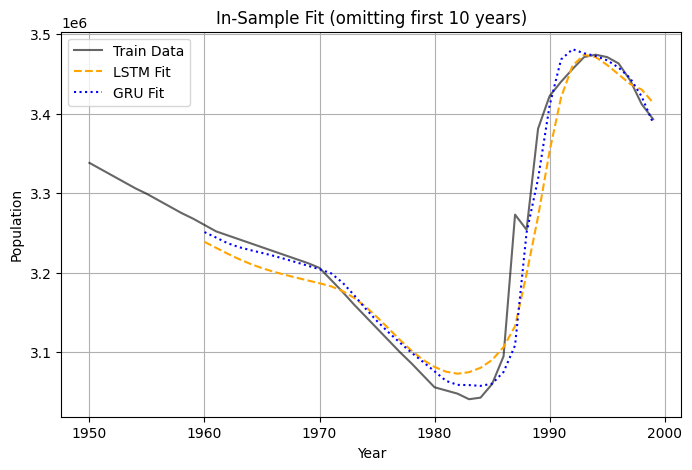

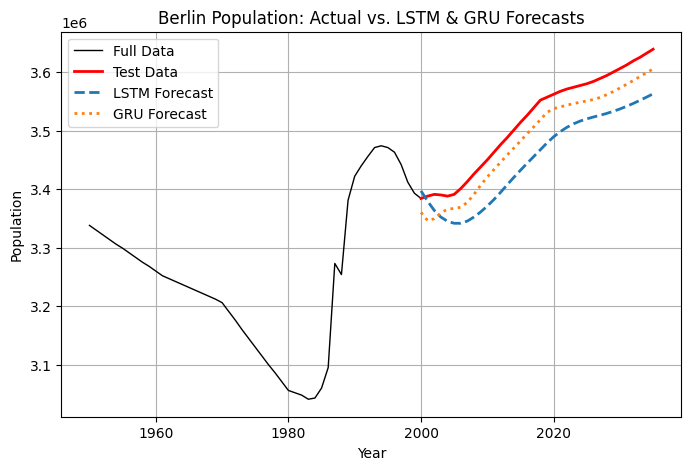

In [3]:
#  Small area population forecasts with LSTM & GRU models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

# Train/test split
test_size = 36  # years for testing
train_df = df.iloc[:-test_size]
test_df  = df.iloc[-test_size:]

# Prepare raw features & targets
X_train = train_df['year'].values.reshape(-1, 1)
y_train = train_df['population'].values
X_test  = test_df['year'].values.reshape(-1, 1)
y_test  = test_df['population'].values

# Scale population series using train data only
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df['population'].values.reshape(-1, 1))

# Create sequences for both models
sequence_length = 10  # years for sliding window
def make_sequences(scaled_series, seq_len):
    X, y = [], []
    for i in range(seq_len, len(scaled_series)):
        X.append(scaled_series[i-seq_len:i, 0])
        y.append(scaled_series[i, 0])
    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y)
    return X, y

x_train_seq, y_train_seq = make_sequences(train_scaled, sequence_length)

# ---- LSTM Model ----
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_seq, y_train_seq, epochs=12, batch_size=1, verbose=1)

# ---- GRU Model ----
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(sequence_length, 1)),
    GRU(50),
    Dense(1)
])
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(x_train_seq, y_train_seq, epochs=12, batch_size=1, verbose=1)

# Prepare full series to create test sequences
full_scaled = scaler.transform(df['population'].values.reshape(-1, 1))
inputs = full_scaled[-(test_size + sequence_length):, 0]
x_test_seq = np.array([inputs[i-sequence_length:i] for i in range(sequence_length, len(inputs))])
x_test_seq = x_test_seq.reshape(-1, sequence_length, 1)

# Forecast with each model
pred_lstm_scaled = lstm_model.predict(x_test_seq, verbose=0)
pred_gru_scaled  = gru_model.predict(x_test_seq, verbose=0)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled).flatten()
pred_gru  = scaler.inverse_transform(pred_gru_scaled).flatten()

# In‐sample (train) fit for comparison
pred_lstm_train = scaler.inverse_transform(
    lstm_model.predict(x_train_seq, verbose=0).reshape(-1,1)
).flatten()
pred_gru_train = scaler.inverse_transform(
    gru_model.predict(x_train_seq, verbose=0).reshape(-1,1)
).flatten()
years_train_seq = train_df['year'].values[sequence_length:]

# --- Plot 1: In‐Sample Fit ---
plt.figure(figsize=(8,5))
plt.plot(train_df['year'], y_train, label='Train Data', color='black', alpha=0.6)
plt.plot(years_train_seq, pred_lstm_train, label='LSTM Fit', color='orange', linestyle='--')
plt.plot(years_train_seq, pred_gru_train,  label='GRU Fit',  color='blue',   linestyle=':')
plt.title(f'In‐Sample Fit (omitting first {sequence_length} years)')
plt.xlabel('Year'); plt.ylabel('Population')
plt.legend(); plt.grid(True)
plt.show()

# --- Plot 2: Forecast Comparison ---
plt.figure(figsize=(8,5))
plt.plot(df['year'], df['population'],             label='Full Data', color='black', linewidth=1)
plt.plot(test_df['year'], y_test,                  label='Test Data',  color='red', linewidth=2)
plt.plot(test_df['year'], pred_lstm,               label='LSTM Forecast', linestyle='--', linewidth=2)
plt.plot(test_df['year'], pred_gru,                label='GRU Forecast',  linestyle=':',  linewidth=2)
plt.title('Berlin Population: Actual vs. LSTM & GRU Forecasts')
plt.xlabel('Year'); plt.ylabel('Population')
plt.legend(); plt.grid(True)
plt.show()


In [4]:
# Comparing models
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# Compute metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'Model': ['LSTM', 'GRU'],
    'MSE': [
        mean_squared_error(y_test, pred_lstm),
        mean_squared_error(y_test, pred_gru)
    ],
    'RMSE': [
        rmse(y_test, pred_lstm),
        rmse(y_test, pred_gru)
    ],
    'MAE': [
        mean_absolute_error(y_test, pred_lstm),
        mean_absolute_error(y_test, pred_gru)
    ],
    'MAPE (%)': [
        mean_absolute_percentage_error(y_test, pred_lstm) * 100,
        mean_absolute_percentage_error(y_test, pred_gru)  * 100
    ],
    'R2': [
        r2_score(y_test, pred_lstm),
        r2_score(y_test, pred_gru)
    ]
}

metrics_df = pd.DataFrame(metrics)

# Round for readability
metrics_df[['MSE','RMSE','MAE','MAPE (%)','R2']] = \
    metrics_df[['MSE','RMSE','MAE','MAPE (%)','R2']].round(4)

print(metrics_df.to_markdown(index=False))

print("Question: is R2 a good measure?")
print("Question: which one is the best model?")

| Model   |         MSE |    RMSE |     MAE |   MAPE (%) |     R2 |
|:--------|------------:|--------:|--------:|-----------:|-------:|
| LSTM    | 4.60762e+09 | 67879.5 | 65328.6 |     1.852  | 0.3598 |
| GRU     | 9.77636e+08 | 31267.2 | 30991.3 |     0.8817 | 0.8642 |
Question: is R2 a good measure?
Question: which one is the best model?
